# Data Science Task - Spam Detection - word2vec embeddings with LSTM<a class='tocSkip'>

The *olx_spam_data__training_set.csv* contains ads data from the Real Estate category with a label indicating if it’s spam.
The task is to build and train a model that allows to identify spam content based on the provided ad parameter.

### NOTE:

**Both word2vec model (~600mb) and LSTM trained model with word index (~600mb) you can download from this link:**<br> 
https://drive.google.com/open?id=1fuzbVOnq16-CBPNtrZSzRwbfRpBjnWIU

## Importing libraries

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from scipy import interp
from itertools import cycle
from time import time

import pickle
import h5py

#!pip install livelossplot
from livelossplot import PlotLossesKeras

import gensim
from gensim.models import Word2Vec, KeyedVectors, word2vec
from gensim.utils import simple_preprocess

from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.preprocessing import sequence
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping

from wordcloud import WordCloud
from many_stop_words import get_stop_words

np.random.seed(42)

## Loading dataset

In [ ]:
# Training Set
training_set = 'data/olx_spam_data__training_set.csv'
df_train = pd.read_csv(training_set, sep=None, engine='python', encoding='utf-8')
print('Training set ready.')

In [3]:
df_train.head()

,ID,TITLE,DESCRIPTION,PRICE,SPAM_FLAG,Unnamed: 5
0,43925,Pracownia plastyczna 'artystart'/Fundacja Serd...,"FUNDACJA SERDECZNIK zaprasza dzieci, młodzie...",50,1,NaN
1,67238,Owczarki Niemieckie Długowłose-OGROMNE- Owczar...,"Szczenięta tylko i wyłącznie rodowodowe: FCI ,...",3500,1,NaN
2,93863,Tusz (Kardridż) HP 41,Oryginalny kardridż firmy HP 41. Zapakowany w ...,5,1,NaN
3,126634,Zespół muzyczny ODLOT,. Zapewniamy profesjonalną oprawę muzyczną na ...,2500,1,NaN
4,169161,Super kultowa książka Moja dziewczyna,"Sprzedam lub zamienię (na kosmetyki, biżuteri...",5,1,NaN


In [4]:
# Dropping two useless columns
df_train.drop(['ID','TITLE','PRICE','Unnamed: 5'], axis=1, inplace=True)

In [5]:
df_train.head()

,DESCRIPTION,SPAM_FLAG
0,"FUNDACJA SERDECZNIK zaprasza dzieci, młodzie...",1
1,"Szczenięta tylko i wyłącznie rodowodowe: FCI ,...",1
2,Oryginalny kardridż firmy HP 41. Zapakowany w ...,1
3,. Zapewniamy profesjonalną oprawę muzyczną na ...,1
4,"Sprzedam lub zamienię (na kosmetyki, biżuteri...",1


## Spliting train set

Split data into training (60%),  test (20%) and validation (20%) set:

In [6]:
X = df_train['DESCRIPTION']
y = df_train['SPAM_FLAG']

# Train/Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train/validation split from recent Train batch
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [7]:
print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)
print('X_val shape:', X_val.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)
print('y_val shape:', y_val.shape)

X_train shape: (6111,)
X_test shape: (1910,)
X_val shape: (1528,)
y_train shape: (6111,)
y_test shape: (1910,)
y_val shape: (1528,)


## Word2vec model embeddings

Polish Word2vec model comes from Polish Academy of Science:
http://dsmodels.nlp.ipipan.waw.pl/

In [8]:
w2v_model = gensim.models.KeyedVectors.load_word2vec_format('data/nkjp+wiki-lemmas-all-100-skipg-hs.txt', binary=False)

# The raw vectors array of words 
embeddings = w2v_model.vectors
print('Shape of embedding matrix: ', embeddings.shape)

Shape of embedding matrix:  (1549322, 100)


In [9]:
# sample embedding
embeddings[0]

array([-0.067263, -0.278751, -0.060967,  0.003641, -0.085972, -0.007591,
        0.175646, -0.040297,  0.031609, -0.282016,  0.077154,  0.15416 ,
       -0.308216,  0.055151, -0.025324,  0.457356,  0.073446, -0.187764,
        0.321959, -0.429217, -0.015667, -0.070864, -0.032553,  0.131034,
        0.110412,  0.213003, -0.206347,  0.115705, -0.29361 , -0.558515,
        0.094456,  0.041231, -0.371049,  0.346143, -0.016075,  0.038274,
       -0.201536,  0.328319, -0.500992,  0.191577, -0.297587, -0.023372,
        0.101364,  0.044869,  0.567448,  0.357061, -0.155775, -0.146237,
       -0.044613, -0.183479,  0.162368, -0.246402,  0.072569, -0.309918,
       -0.333774, -0.290704,  0.244227, -0.295435, -0.168995,  0.301849,
        0.076989,  0.494596, -0.1482  ,  0.115709,  0.433078, -0.101339,
        0.375264, -0.174559, -0.062852, -0.175365, -0.117006, -0.109267,
        0.088535,  0.042023, -0.305528, -0.186444,  0.194347,  0.167598,
       -0.086507,  0.081446,  0.222216,  0.17581 , 

Tokenizing and transforming all X_s into sequences

In [10]:
# the maximum number of words to keep, based on word frequency
num_words = embeddings.shape[0]
# maximum length of all sequences
maxlen = 100
# two spam classes to predict
nb_classes = 2

In [11]:
# Tokenizing
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(X_train)

# Transforming
seq_train = tokenizer.texts_to_sequences(X_train)
seq_test = tokenizer.texts_to_sequences(X_test)
seq_val = tokenizer.texts_to_sequences(X_val)

In [12]:
# Sample sequence
seq_train[0][:15]

[4, 22, 10, 24, 1, 40, 11374, 11375, 35, 92, 71, 31, 1447, 201, 85]

In [13]:
# Word index as a dictionary
word_index = tokenizer.word_index
print('Number of unique tokens: {}'.format(len(word_index)))
print('Sample:', list(word_index.keys())[:10])

Number of unique tokens: 28863
Sample: ['w', 'na', 'z', 'do', 'i', 'mieszkanie', 'jest', 'się', 'od', '2']


In [14]:
# Pads sequences to the same length of 100
X_train = sequence.pad_sequences(seq_train, maxlen=maxlen)
X_test = sequence.pad_sequences(seq_test, maxlen=maxlen)
X_val = sequence.pad_sequences(seq_val, maxlen=maxlen)

# Converts a class vector (integers) to binary class matrix.
y_train = np_utils.to_categorical(y_train, nb_classes)
y_test = np_utils.to_categorical(y_test, nb_classes)
y_val = np_utils.to_categorical(y_val, nb_classes)

In [15]:
X_train.shape, X_test.shape, X_val.shape

((6111, 100), (1910, 100), (1528, 100))

In [16]:
y_train

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [0., 1.],
       [0., 1.]], dtype=float32)

## LSTMs

In [17]:
# Turning indexes into dense vectors of fixed size
embedding_layer = Embedding(embeddings.shape[0],
                            embeddings.shape[1],
                            weights=[embeddings],
                            trainable=False)

In [18]:
# Input dims
embeddings.shape[0], embeddings.shape[1]

(1549322, 100)

In [19]:
# Two spam classes
nb_classes

2

In [125]:
model = Sequential()
model.add(embedding_layer)
model.add(LSTM(128, recurrent_dropout=0.5, dropout=0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         154932200 
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 258       
_________________________________________________________________
activation_7 (Activation)    (None, 2)                 0         
Total params: 155,049,706
Trainable params: 117,506
Non-trainable params: 154,932,200
_________________________________________________________________


In [127]:
# Compiling model using Adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [128]:
# Declaring size of batch and number of epochs
batch_size = 32
epochs = 50

In [129]:
# Declaring callback to stop after not improving accuracy in 3 consecutive epochs
early_stopping = EarlyStopping(patience=3)

In [130]:
lstm_model = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                       validation_data=(X_val, y_val), shuffle=True,
                       callbacks=[early_stopping])
score = model.evaluate(X_val, y_val)

print('Test Loss: {:.2f}'.format(score[0]*100))
print('Test Accuracy: {:.2f}'.format(score[1]*100))

Train on 6111 samples, validate on 1528 samples
Epoch 1/50
6111/6111 [==============================] - 61s 10ms/step - loss: 0.6435 - acc: 0.6300 - val_loss: 0.4894 - val_acc: 0.7762
Epoch 2/50
6111/6111 [==============================] - 35s 6ms/step - loss: 0.5614 - acc: 0.7172 - val_loss: 0.4497 - val_acc: 0.7997
Epoch 3/50
6111/6111 [==============================] - 34s 6ms/step - loss: 0.5336 - acc: 0.7382 - val_loss: 0.4463 - val_acc: 0.7971
Epoch 4/50
6111/6111 [==============================] - 37s 6ms/step - loss: 0.4982 - acc: 0.7619 - val_loss: 0.3919 - val_acc: 0.8187
Epoch 5/50
6111/6111 [==============================] - 35s 6ms/step - loss: 0.4737 - acc: 0.7811 - val_loss: 0.3716 - val_acc: 0.8397
Epoch 6/50
6111/6111 [==============================] - 36s 6ms/step - loss: 0.4454 - acc: 0.7948 - val_loss: 0.3528 - val_acc: 0.8488
Epoch 7/50
6111/6111 [==============================] - 38s 6ms/step - loss: 0.4155 - acc: 0.8171 - val_loss: 0.3139 - val_acc: 0.8678
Epoch 

**Saving model and word_index for future use**

In [131]:
# Saving model
model.save('model/spamclassmodel.h5')

# Saving word index
output = open('model/spamclasswordindex.pkl', 'wb')
pickle.dump(word_index, output)

**Loading previously trained model to save the computing time**

In [132]:
# Loading previously trained model and word index to save time to compute it again
# lstms = load_model('model/spamclassmodel.h5')

#Loading word index
# file = open('model/spamclasswordindex.pkl', 'rb')
# word_index = pickle.load(file)
# file.close()

Checking overfitting on plots.

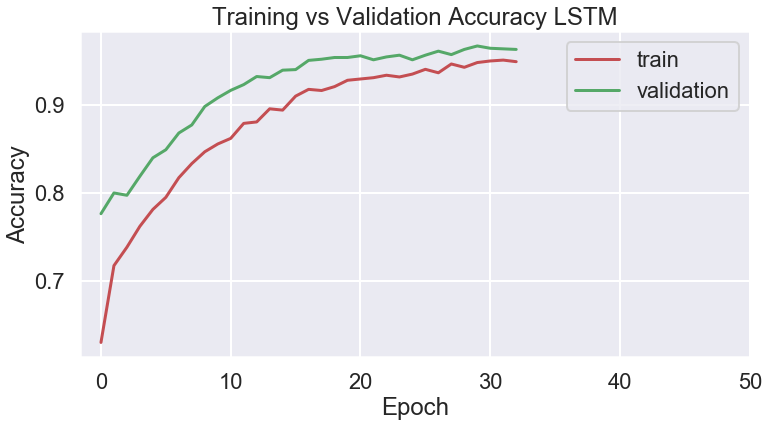

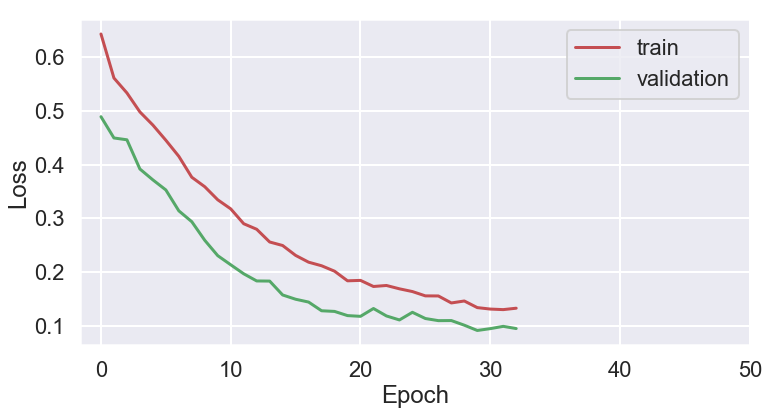

In [133]:
plt.figure(0, figsize=(12,6))
plt.plot(lstm_model.history['acc'],'r')
plt.plot(lstm_model.history['val_acc'],'g')
plt.xticks(np.arange(0, epochs+1, epochs/5))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy LSTM')
plt.legend(['train', 'validation'])

plt.figure(1, figsize=(12,6))
plt.plot(lstm_model.history['loss'],'r')
plt.plot(lstm_model.history['val_loss'],'g')
plt.xticks(np.arange(0, epochs+1, epochs/5))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['train', 'validation'])
plt.show()

**Classification report**

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       929
           1       0.96      0.94      0.95       981

   micro avg       0.95      0.95      0.95      1910
   macro avg       0.95      0.95      0.95      1910
weighted avg       0.95      0.95      0.95      1910



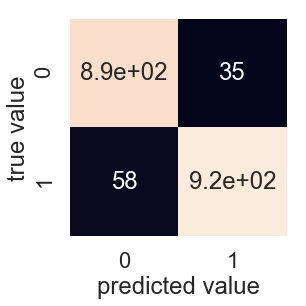

In [141]:
y_pred_ = model.predict(X_test, verbose=2)
y_pred = np.argmax(y_pred_, axis=1)
y_true = np.argmax(y_test, axis=1)

plt.figure(figsize=(4,4))
sns.heatmap(confusion_matrix(y_true, y_pred), square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

print(classification_report(y_true, y_pred))

## ROC curve

AUC: 0.991


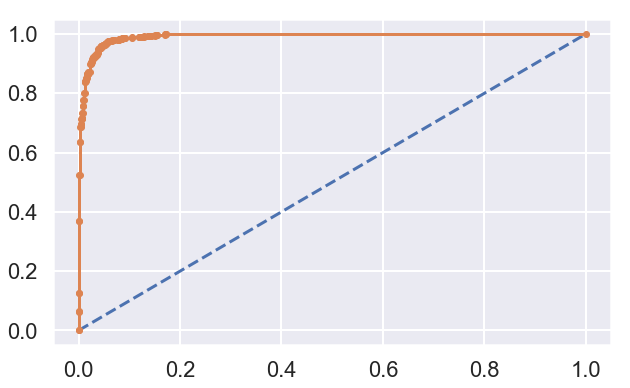

In [135]:
# Probabilities (only positive)
probas = model.predict_proba(X_test)
probas = probas[:, 1]
# AUC
auc = roc_auc_score(y_true, probas)
print('AUC: {:.3f}'.format(auc))
# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, probas)
plt.figure(figsize=(10,6))
# No-skill line
plt.plot([0, 1], [0, 1], linestyle='--')
# Model
plt.plot(fpr, tpr, marker='.')
plt.show()

## Wordcloud

### Spam class

In [136]:
stop_words = get_stop_words('pl')

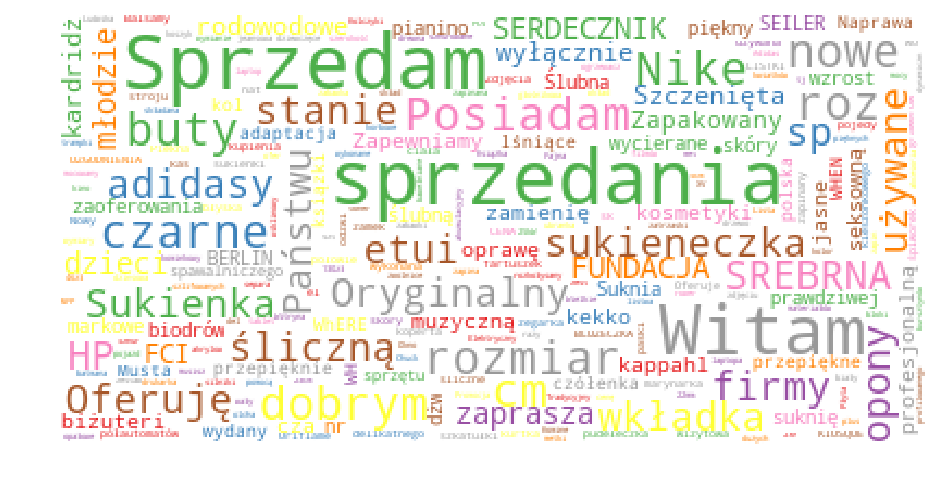

In [137]:
df_spam = df_train[df_train['SPAM_FLAG'] == 1]['DESCRIPTION']

wordcloud = WordCloud(
                      stopwords=stop_words,
                      background_color='white',
                      colormap='Set1_r',
                      max_words=300,
                      max_font_size=35,
                      random_state=42
                     ).generate(str(df_spam))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### No-spam class

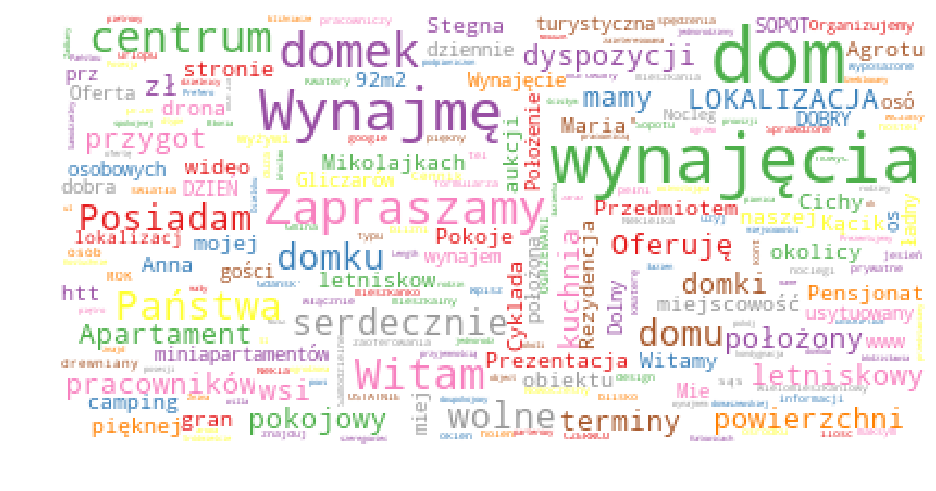

In [138]:
df_ham = df_train[df_train['SPAM_FLAG'] == 0]['DESCRIPTION']

wordcloud = WordCloud(
                      stopwords=stop_words,
                      background_color='white',
                      colormap='Set1_r',
                      max_words=300,
                      max_font_size=35,
                      random_state=42
                     ).generate(str(df_ham))

plt.figure(figsize=(16,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()